# 🤖 Entrenamiento del Modelo Predictivo (PyCaret)

## 🎯 Objetivo
Este notebook orquesta el pipeline de entrenamiento de Machine Learning utilizando **PyCaret**.
El objetivo es encontrar y optimizar el mejor algoritmo capaz de predecir la probabilidad de **Enfermedad Cardíaca** basándose en biomarcadores clínicos.

## ⚙️ Estrategia de Modelado
1. **Preprocesamiento Robusto**: Normalización y manejo de outliers.
2. **Balanceo de Clases**: Uso de técnicas (SMOTE) para mitigar el desbalance entre pacientes sanos y enfermos.
3. **Optimización de Recall**: Priorizamos la **Sensibilidad (Recall)** sobre la Precisión.
   - *Contexto Médico*: Es peor no detectar a un enfermo (Falso Negativo) que alarmar a un sano (Falso Positivo).
4. **Selección de Modelos**: Comparación automática de +15 algoritmos.

## 📂 Entradas y Salidas
- **Input**: `data/02_intermediate/process_data.parquet` (Datos limpios).
- **Output**: `models/best_pipeline.pkl` (Modelo serializado listo para producción).

## 1. Configuración del Entorno

Definimos parámetros globales.
- **SAMPLE_FRAC**: Porcentaje de datos a usar. Para pruebas rápidas usamos `0.5`, para el modelo final debe ser `1.0`.
- **Rutas**: Ubicación de datos y donde se guardarán los artefactos.

### 🔹 Paso 1: Configuración del Entorno y Constantes
Inicializamos el entorno de trabajo importando **PyCaret** y definiendo constantes críticas:
- `SAMPLE_FRAC`: Controla el muestreo de datos. Usamos 0.5 (50%) para iteraciones rápidas de desarrollo, pero se debe cambiar a 1.0 para el entrenamiento final.
- `DATA_PATH` y `MODEL_DIR`: Definen las rutas de entrada de datos y salida del modelo, asegurando una estructura de proyecto ordenada.

In [1]:
import pandas as pd
from pycaret.classification import *
import os
import json

# ==========================================
# CONFIGURATION
# ==========================================
SAMPLE_FRAC = 0.05  # Modified for quick test
DATA_PATH = "../data/02_intermediate/process_data.parquet"
MODEL_DIR = "../models"
MODEL_NAME = "best_pipeline"
CONFIG_PATH = "../models/model_config.json"

print(f"Running Training with SAMPLE_FRAC = {SAMPLE_FRAC}")

Running Training with SAMPLE_FRAC = 0.05


## 2. Carga y Filtrado de Datos

Cargamos el dataset y aplicamos el esquema definido en `model_config.json`.
Es vital entrenar **solo** con las columnas que estarán disponibles en la aplicación final (Features + Target), descartando metadatos o IDs que causarían *data leakage*.

### 🔹 Paso 2: Carga y Selección de Features (Data Loading)
Cargamos el dataset procesado y aplicamos un filtro estricto de columnas basado en `model_config.json`.
**Importante**:
- Solo cargamos las columnas definidas como `features` y el `target`.
- Esto actúa como una barrera de seguridad contra el *data leakage*, asegurando que el modelo no vea variables que no estarán disponibles en producción (como IDs de pacientes o fechas de procesamiento).

In [2]:
# ==========================================
# 1. LOAD DATA
# ==========================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
print(f"Original Data Shape: {df.shape}")

# --- CORRECCIÓN: Definición manual de columnas para romper dependencia circular ---
# Definir manualmente las columnas basadas en tu EDA
numeric_features = [
    "Age", "SystolicBP", "TotalCholesterol", "LDL", "Triglycerides", 
    "HbA1c", "Glucose", "UricAcid", "Creatinine", "BMI", 
    "WaistCircumference", "Height", "IncomeRatio", 
    "ALT_Enzyme", "AST_Enzyme", "GGT_Enzyme", 
    "Albumin", "Potassium", "Sodium"
]

categorical_features = [
    "Sex", "Race", "Education", "Smoking", 
    "Alcohol", "PhysicalActivity", "HealthInsurance"
]

target = "HeartDisease"

features = numeric_features + categorical_features

print(f"Target: {target}")
print(f"Numeric Features: {len(numeric_features)}")
print(f"Categorical Features: {len(categorical_features)}")

# Filter only relevant columns
df = df[features + [target]]

if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42)
    print(f"Sampled Data Shape: {df.shape}")
else:
    print("Using Full Dataset")


Original Data Shape: (43695, 29)
Target: HeartDisease
Numeric Features: 19
Categorical Features: 7
Sampled Data Shape: (2185, 27)


## 3. Configuración del Experimento (Setup)

La función `setup()` inicializa el entorno de PyCaret y crea el pipeline de transformación.
- **normalize=True**: Escala las variables para que tengan rangos comparables. Usamos `RobustScaler` para ser resilientes a outliers.
- **remove_outliers=True**: Elimina anomalías estadísticas que podrían sesgar el modelo.
- **fix_imbalance=True**: Aplica SMOTE para generar muestras sintéticas de la clase minoritaria (Enfermos), mejorando el aprendizaje.

### 🔹 Paso 3: Inicialización del Experimento (PyCaret Setup)
Configuramos el pipeline de preprocesamiento automático con `setup()`. Aquí definimos la "magia" de PyCaret:
- **Normalización**: Aplicamos `RobustScaler` (`normalize_method='robust'`) para escalar los datos manejando bien los outliers típicos de datos clínicos.
- **Balanceo de Clases**: Activamos `fix_imbalance=True` (SMOTE) para generar datos sintéticos de la clase minoritaria (pacientes enfermos), evitando que el modelo se sesgue hacia la clase mayoritaria (sanos).
- **Tipos de Datos**: Definimos explícitamente cuáles son numéricas y cuáles categóricas.

In [3]:
# ==========================================
# 2. SETUP PYCARET
# ==========================================
# normalize=True (RobustScaler)
# remove_outliers=True
# fix_imbalance=True

exp = setup(
    data=df,
    target=target,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    normalize=True,
    normalize_method='robust',
    remove_outliers=True,
    fix_imbalance=True,
    session_id=42,
    verbose=True,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,HeartDisease
2,Target type,Binary
3,Original data shape,"(2185, 27)"
4,Transformed data shape,"(3482, 33)"
5,Transformed train set shape,"(2826, 33)"
6,Transformed test set shape,"(656, 33)"
7,Ordinal features,1
8,Numeric features,19
9,Categorical features,7


## 4. Comparación y Selección de Modelos

Entrenamos múltiples algoritmos (Logistic Regression, XGBoost, Random Forest, etc.) con validación cruzada (Cross-Validation).
**Métrica Clave: Recall**. Buscamos maximizar la capacidad del modelo para detectar casos positivos reales.

In [4]:
import numpy as np

# ==========================================
# 3. SELECCIÓN DE MODELO (Model Selection)
# ==========================================
# Estrategia: Comparar modelos basados en árboles y seleccionar los Top 3 para tuning.
# Restricción: Solo árboles (XGBoost, LightGBM)
# Métrica: Recall (Sensibilidad)

top_models = compare_models(
        sort='Recall',
    n_select=3,
    verbose=True
)
print(f"Top 3 Models: {top_models}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6854,0.8153,0.7900,0.0685,0.1255,0.0779,0.1677,0.3840
ridge,Ridge Classifier,0.8188,0.0000,0.7450,0.1088,0.1891,0.1474,0.2372,0.3020
lda,Linear Discriminant Analysis,0.8182,0.8614,0.7450,0.1084,0.1886,0.1468,0.2366,0.4010
svm,SVM - Linear Kernel,0.8404,0.0000,0.6700,0.1150,0.1955,0.1551,0.2308,0.3170
lr,Logistic Regression,0.8450,0.8495,0.6450,0.1119,0.1899,0.1494,0.2223,0.8910
knn,K Neighbors Classifier,0.8548,0.7639,0.6250,0.1139,0.1917,0.1517,0.2216,0.4280
ada,Ada Boost Classifier,0.9339,0.7554,0.2450,0.1450,0.1801,0.1495,0.1555,1.1700
gbc,Gradient Boosting Classifier,0.9581,0.8638,0.1600,0.2056,0.1676,0.1503,0.1566,3.0370
dt,Decision Tree Classifier,0.9372,0.5477,0.1350,0.0969,0.1064,0.0762,0.0800,0.4540
qda,Quadratic Discriminant Analysis,0.9555,0.7055,0.0900,0.0617,0.0690,0.0510,0.0541,0.3790


Top 3 Models: [GaussianNB(priors=None, var_smoothing=1e-09), RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=42, solver='auto',
                tol=0.0001), LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)]


### 🔹 Paso 4.1: Optimización Profunda de Hiperparámetros
Ya tenemos el mejor candidato ('best_model'). Ahora, no nos conformamos con sus parámetros por defecto. 
Ejecutamos un proceso de **Tuning Exhaustivo**:
- **optimize='Recall'**: El algoritmo de búsqueda intentará maximizar específicamente la sensibilidad.
- **n_iter=50**: Probamos 50 combinaciones de hiperparámetros distintas. ¿Por qué 50? En medicina, la diferencia entre un recall del 85% y 87% puede significar salvar más vidas (menos Falsos Negativos). Una búsqueda superficial (n_iter=10) podría perder el óptimo global.
- **choose_better=True**: Si después de tunear el modelo empeora, nos quedamos con la versión original.

In [5]:
# ==========================================
# 3.1 DEEP HYPERPARAMETER TUNING
# ==========================================
best_model = top_models[0]
print(f"\n--- Tuning Best Model: {type(best_model).__name__} ---")

# Tuning loop
# n_iter=2 para búsqueda exhaustiva (Deep Search)
tuned_model = tune_model(
    best_model, 
    optimize='Recall', 
    n_iter=2, 
    choose_better=True, 
    verbose=False
)

print(f"\nFINAL BEST MODEL SELECTED: {tuned_model}")


--- Tuning Best Model: GaussianNB ---



FINAL BEST MODEL SELECTED: GaussianNB(priors=None, var_smoothing=1e-09)


### 🔹 Paso 4.2: Optimización de Umbral de Decisión

Implementamos la estrategia **Precision-Constrained Recall Maximization**.
Buscamos el umbral que maximice el Recall, sujeto a que la Precisión sea >= 0.4.


--- Optimizando Umbral de Decisión ---


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


⚠️ No se alcanzó la zona segura (Precision >= 0.4). Se usará umbral por defecto (0.5).


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


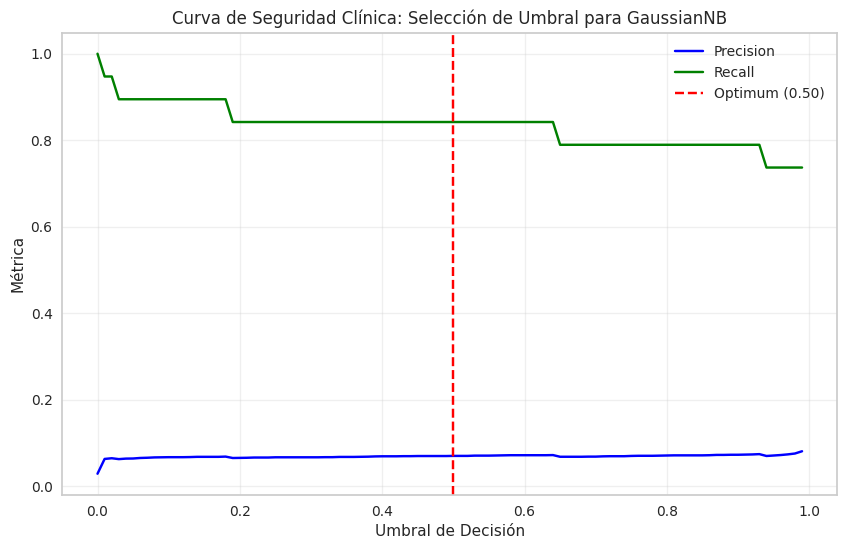

In [6]:
# 3. Estrategia de Umbral de Seguridad Clínica
print("\n--- Optimizando Umbral de Decisión ---")
# Generar probabilidades en el set de validación (hold-out)
predictions = predict_model(tuned_model, raw_score=True, verbose=False)

# Identificar columnas de score y target real
target_col = get_config('target_param')
y_true = predictions[target_col]

# Buscar columna de score para clase positiva (1)
score_cols = [c for c in predictions.columns if 'score' in c]
if any('1' in c for c in score_cols):
    score_col = [c for c in score_cols if '1' in c][0]
else:
    score_col = score_cols[0]

y_scores = predictions[score_col]

# Iterar umbrales
thresholds = np.arange(0.0, 1.0, 0.01)
results = []

from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    results.append({'Threshold': t, 'Precision': prec, 'Recall': rec})

results_df = pd.DataFrame(results)

# Filtrar zona segura: Precision >= 0.4
safe_zone = results_df[results_df['Precision'] >= 0.4]

if not safe_zone.empty:
    # Seleccionar el umbral con mayor Recall dentro de la zona segura
    # (Generalmente el umbral más bajo de la zona)
    best_row = safe_zone.sort_values('Recall', ascending=False).iloc[0]
    optimal_threshold = best_row['Threshold']
    print(f"✅ Umbral Óptimo Encontrado: {optimal_threshold:.2f}")
    print(f"   Métricas Esperadas -> Recall: {best_row['Recall']:.4f} | Precision: {best_row['Precision']:.4f}")
else:
    print("⚠️ No se alcanzó la zona segura (Precision >= 0.4). Se usará umbral por defecto (0.5).")
    optimal_threshold = 0.5

# Visualización de la Curva de Seguridad
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', color='blue')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', color='green')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimum ({optimal_threshold:.2f})')

# Sombrear zona segura si existe
if not safe_zone.empty:
    plt.axvspan(safe_zone['Threshold'].min(), safe_zone['Threshold'].max(), alpha=0.1, color='green', label='Zona Segura (Prec>=0.4)')

plt.title(f"Curva de Seguridad Clínica: Selección de Umbral para {type(tuned_model).__name__}")
plt.xlabel("Umbral de Decisión")
plt.ylabel("Métrica")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5. Finalización y Persistencia

Una vez seleccionado el mejor modelo:
1. **Finalize**: Se re-entrena el modelo utilizando el 100% de los datos (incluyendo el set de prueba reservado anteriormente).
2. **Save**: Se guarda el pipeline completo (preprocesamiento + modelo) en un archivo `.pkl` para su despliegue en la API/Streamlit.

### 🔹 Paso 5: Finalización y Serialización del Modelo
Una vez seleccionado el mejor algoritmo:
1.  **Finalize**: Re-entrenamos el modelo utilizando **todos** los datos disponibles (incluyendo el set de validación que PyCaret retuvo internamente).
2.  **Save**: Guardamos el pipeline completo como un archivo `.pkl` en el directorio `models/`. Este archivo contiene tanto el modelo predictivo como las transformaciones de datos (escalado, imputación), listo para ser consumido por la API.

## 4.5 Explicabilidad del Modelo (SHAP)

Validamos que el modelo no tome decisiones basadas en artefactos o sesgos. Generamos el **SHAP Summary Plot** para visualizar las variables más impactantes.
Esto es un requisito de **Transparencia Algorítmica** para la auditoría.

In [7]:
# Generar SHAP Summary Plot
print("Generando explicaciones SHAP...")
try:
    interpret_model(tuned_model, plot='summary')
except Exception as e:
    print(f"No se pudo generar el gráfico SHAP (probablemente el modelo no lo soporte nativamente o falte librería): {e}")


Generando explicaciones SHAP...


No se pudo generar el gráfico SHAP (probablemente el modelo no lo soporte nativamente o falte librería): This function only supports tree based models for binary classification: dt, et, xgboost, rf, lightgbm.


In [8]:
# ==========================================
# 4. FINALIZE & SAVE
# ==========================================
final_model = finalize_model(tuned_model)
os.makedirs(MODEL_DIR, exist_ok=True)
save_path = os.path.join(MODEL_DIR, MODEL_NAME)
save_model(final_model, save_path)
print(f"Model saved successfully to {save_path}.pkl")

Transformation Pipeline and Model Successfully Saved
Model saved successfully to ../models/best_pipeline.pkl
